<a href="https://colab.research.google.com/github/gspiga/TweetSentimentAnalysis/blob/main/bertie_boy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
nltk.download('stopwords')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

EDA

In [3]:
my_data=pd.read_csv("Tweets.csv")


RNN

In [4]:
def clean_text(text):
    text = re.sub(r'http\S+', '', text)   # Remove URLs
    text = re.sub(r'<.*?>', '', text)     # Remove HTML tags
    text = re.sub(r'[^\w\s]', '', text)   # Remove punctuation and special chars
    text = text.lower()                   # Convert to lowercase
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stopwords.words('english')])
    return text

my_data['cleaned_text'] = my_data['text'].apply(clean_text)


In [5]:
clean_text("My @Southwest flight was delayed AGAIN!! Airline rep was entirely unhelpful :()")

'southwest flight delayed airline rep entirely unhelpful'

In [6]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(my_data['cleaned_text'])
sequences = tokenizer.texts_to_sequences(my_data['cleaned_text'])

# Define maximum sequence length
max_seq_length = max([len(x) for x in sequences])
word_index = tokenizer.word_index
print(f'Found {len(word_index)} unique tokens.')

data = pad_sequences(sequences, maxlen=max_seq_length)


Found 15402 unique tokens.


In [7]:
le = LabelEncoder()
my_data['sentiment'] = le.fit_transform(my_data['airline_sentiment'])


In [8]:
labels = my_data['sentiment'].values
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)


In [ ]:
from torch.utils.data import Dataset, DataLoader

class TweetDataset(Dataset):
    def __init__(self, tweets, labels):
        self.tweets = tweets
        self.labels = labels

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, idx):
        tweet = self.tweets[idx]
        label = self.labels[idx]
        return tweet, label

# Assuming X_train, y_train are your input and output training data
train_dataset = TweetDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=False)





In [ ]:
import torch
import torch.nn as nn

class SentimentModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers,
                 bidirectional, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers,
                   bidirectional=bidirectional, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
      #print("Input text shape:", text.size())  # Debug, working now
      embedded = self.dropout(self.embedding(text))
      #print("After embedding:", embedded.size())  # Debug, working now
      output, (hidden, cell) = self.rnn(embedded)
      #print("Output shape:", output.size(), "Hidden shape:", hidden.size())  # Debug, working nw!

      hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
      hidden = self.dropout(hidden)

      # Ensure the hidden state is correctly reshaped for the fully connected layer
      hidden = hidden.view(hidden.shape[0], -1)  # Reshape without squeezing
      return self.fc(hidden)



# Example parameters
tokenizer = Tokenizer()
tokenizer.fit_on_texts(my_data['cleaned_text'])
word_index = tokenizer.word_index

# Add 1 because the index 0 is reserved and not assigned to any word
vocab_size = len(word_index) + 1
embedding_dim = 100
hidden_dim = 256
output_dim = 3 # for 3 sentiment classes
n_layers = 2
bidirectional = True
dropout = 0.5

model = SentimentModel(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout)


In [ ]:
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss() # use CrossEntropyLoss for multi-class classification
optimizer = optim.Adam(model.parameters())

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    for tweets, labels in train_loader:
        optimizer.zero_grad()
        #print("Input shape:", tweets.size())  # Debugging print
        predictions = model(tweets)
        #print("Output shape:", predictions.size(), "Labels shape:", labels.size())  # Debugging print
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}: Loss = {loss.item()}')


Epoch 1: Loss = 0.6884427070617676
Epoch 2: Loss = 0.5450142621994019
Epoch 3: Loss = 0.8621058464050293
Epoch 4: Loss = 0.46893492341041565
Epoch 5: Loss = 0.5513229966163635


In [ ]:
from torch.utils.data import TensorDataset, DataLoader

# Convert test data to PyTorch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create a TensorDataset
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create a DataLoader
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    total_correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            total_correct += (predicted == labels).sum().item()

    accuracy = total_correct / total
    return accuracy


In [ ]:
accuracy = evaluate_model(model, test_loader)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


Test Accuracy: 77.36%


BERT

In [ ]:
#!pip install transformers

In [9]:
import torch
from transformers import TFBertForSequenceClassification,AutoTokenizer,BertTokenizer,AdamW,get_linear_schedule_with_warmup,AutoModel,BertModel

In [31]:
my_data['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [35]:
indices_to_remove = my_data[my_data['airline_sentiment']=='negative'].head(5000).index
balanced_df = my_data.drop(indices_to_remove)

In [37]:
balanced_df['airline_sentiment'].value_counts()

negative    4178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [28]:
from imblearn.under_sampling import RandomUnderSampler

column_name = 'airline_sentiment'
rus = RandomUnderSampler()
X_resampled, y_resampled = rus.fit_resample(my_data[[column_name]], my_data[column_name])

In [11]:
train_data, val_data = train_test_split(my_data, test_size=0.2, random_state=42)
#using BERT Encoder with padding and lemmatization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_encoding=tokenizer(list(train_data['cleaned_text']),truncation=True,padding=True)
valid_encoding=tokenizer(list(val_data['cleaned_text']),truncation=True,padding=True)

sentiment_dict = {'positive': 0, 'negative': 1, 'neutral': 2}

train_labels = train_data['airline_sentiment'].map(sentiment_dict).values.astype('int64')
valid_labels = val_data['airline_sentiment'].map(sentiment_dict).values.astype('int64')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [12]:
print(len(train_labels))
print(len(valid_labels))
print(len(train_encoding))
print(len(valid_encoding))

11712
2928
3
3


In [13]:
import tensorflow as tf

In [14]:
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encoding), train_labels)).shuffle(len(train_labels)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((dict(valid_encoding), valid_labels)).batch(32)

# Load the pre-trained BERT model for sequence classification
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

# Fine-tune the model
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
366/366 [==============================] - 168s 316ms/step - loss: 0.6253 - accuracy: 0.7479 - val_loss: 0.4715 - val_accuracy: 0.8166
Epoch 2/10
366/366 [==============================] - 109s 297ms/step - loss: 0.4313 - accuracy: 0.8335 - val_loss: 0.4601 - val_accuracy: 0.8204
Epoch 3/10
366/366 [==============================] - 111s 303ms/step - loss: 0.3034 - accuracy: 0.8893 - val_loss: 0.5709 - val_accuracy: 0.8149
Epoch 4/10
366/366 [==============================] - 112s 306ms/step - loss: 0.1936 - accuracy: 0.9314 - val_loss: 0.5759 - val_accuracy: 0.8159
Epoch 5/10
366/366 [==============================] - 111s 302ms/step - loss: 0.1205 - accuracy: 0.9606 - val_loss: 0.6764 - val_accuracy: 0.8149
Epoch 6/10
366/366 [==============================] - 111s 302ms/step - loss: 0.0804 - accuracy: 0.9741 - val_loss: 0.7584 - val_accuracy: 0.8145
Epoch 7/10
366/366 [==============================] - 113s 309ms/step - loss: 0.0621 - accuracy: 0.9781 - val_loss: 0.8176 -

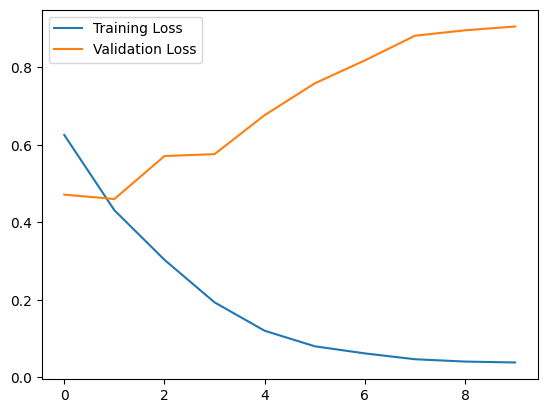

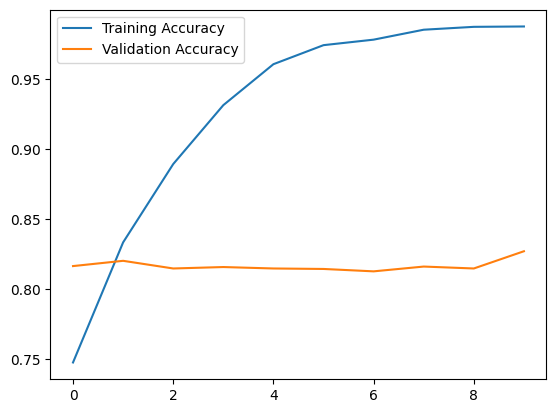

In [15]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [39]:
train_data, val_data = train_test_split(balanced_df, test_size=0.2, random_state=42)
#using BERT Encoder with padding and lemmatization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_encoding=tokenizer(list(train_data['cleaned_text']),truncation=True,padding=True)
valid_encoding=tokenizer(list(val_data['cleaned_text']),truncation=True,padding=True)

sentiment_dict = {'positive': 0, 'negative': 1, 'neutral': 2}

train_labels = train_data['airline_sentiment'].map(sentiment_dict).values.astype('int64')
valid_labels = val_data['airline_sentiment'].map(sentiment_dict).values.astype('int64')

In [40]:
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encoding), train_labels)).shuffle(len(train_labels)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((dict(valid_encoding), valid_labels)).batch(32)

# Load the pre-trained BERT model for sequence classification
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

# Fine-tune the model
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
241/241 [==============================] - 130s 348ms/step - loss: 0.5818 - accuracy: 0.7554 - val_loss: 0.4467 - val_accuracy: 0.8294
Epoch 2/10
241/241 [==============================] - 82s 339ms/step - loss: 0.3698 - accuracy: 0.8563 - val_loss: 0.4074 - val_accuracy: 0.8439
Epoch 3/10
241/241 [==============================] - 81s 337ms/step - loss: 0.2510 - accuracy: 0.9091 - val_loss: 0.4810 - val_accuracy: 0.8314
Epoch 4/10
241/241 [==============================] - 80s 334ms/step - loss: 0.1610 - accuracy: 0.9455 - val_loss: 0.5666 - val_accuracy: 0.8174
Epoch 5/10
241/241 [==============================] - 81s 334ms/step - loss: 0.0987 - accuracy: 0.9699 - val_loss: 0.6562 - val_accuracy: 0.8361
Epoch 6/10
241/241 [==============================] - 76s 314ms/step - loss: 0.0684 - accuracy: 0.9781 - val_loss: 0.7630 - val_accuracy: 0.8164
Epoch 7/10
241/241 [==============================] - 76s 313ms/step - loss: 0.0599 - accuracy: 0.9811 - val_loss: 0.7143 - val_a

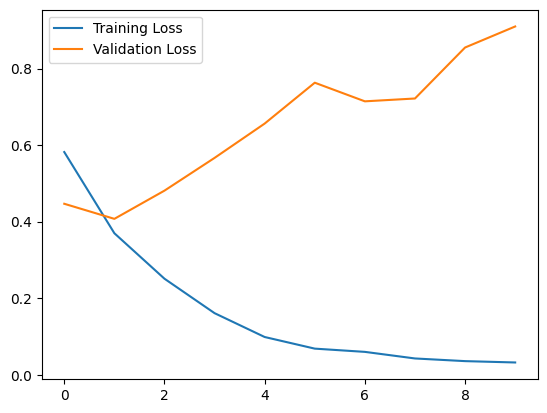

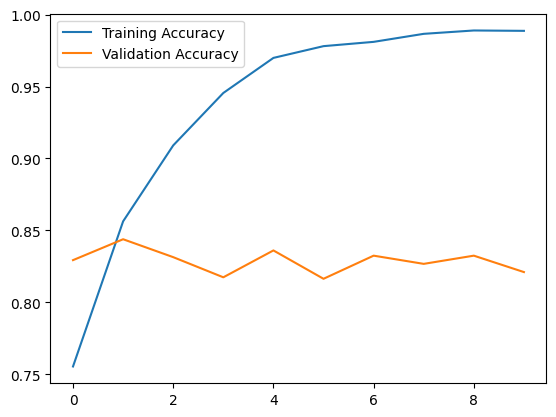

In [41]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [43]:
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encoding), train_labels)).shuffle(len(train_labels)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((dict(valid_encoding), valid_labels)).batch(32)

# Load the pre-trained BERT model for sequence classification
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

# Fine-tune the model
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-6, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
241/241 [==============================] - 133s 368ms/step - loss: 0.8699 - accuracy: 0.5995 - val_loss: 0.6943 - val_accuracy: 0.6971
Epoch 2/10
241/241 [==============================] - 76s 317ms/step - loss: 0.6236 - accuracy: 0.7639 - val_loss: 0.5901 - val_accuracy: 0.7733
Epoch 3/10
241/241 [==============================] - 78s 322ms/step - loss: 0.5282 - accuracy: 0.8036 - val_loss: 0.5292 - val_accuracy: 0.7899
Epoch 4/10
241/241 [==============================] - 81s 334ms/step - loss: 0.4682 - accuracy: 0.8249 - val_loss: 0.5115 - val_accuracy: 0.8008
Epoch 5/10
241/241 [==============================] - 79s 328ms/step - loss: 0.4292 - accuracy: 0.8410 - val_loss: 0.4681 - val_accuracy: 0.8205
Epoch 6/10
241/241 [==============================] - 78s 323ms/step - loss: 0.3957 - accuracy: 0.8505 - val_loss: 0.4746 - val_accuracy: 0.8273
Epoch 7/10
241/241 [==============================] - 76s 314ms/step - loss: 0.3730 - accuracy: 0.8607 - val_loss: 0.4762 - val_a

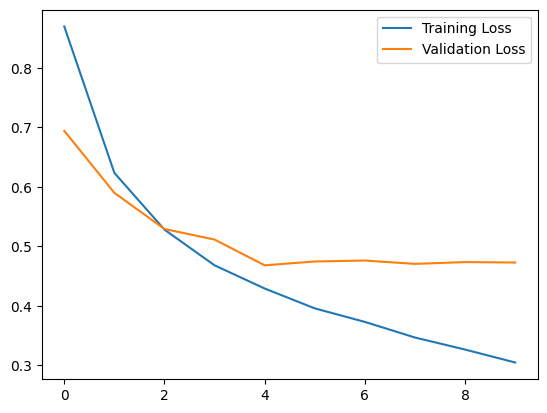

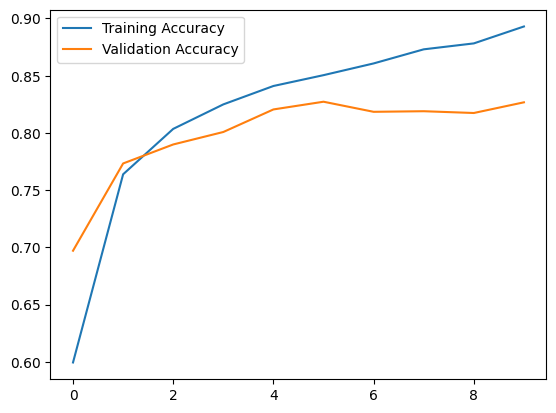

In [45]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
#sub-setting by confidence

In [44]:
balanced_df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,cleaned_text,sentiment
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),virginamerica dhepburn said,1
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),virginamerica plus youve added commercials exp...,2
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),virginamerica didnt today must mean need take ...,1
6,570300616901320704,positive,0.6745,NaN,0.0,Virgin America,NaN,cjmcginnis,NaN,0,"@VirginAmerica yes, nearly every time I fly VX...",NaN,2015-02-24 11:13:57 -0800,San Francisco CA,Pacific Time (US & Canada),virginamerica yes nearly every time fly vx ear...,2
7,570300248553349120,neutral,0.6340,NaN,NaN,Virgin America,NaN,pilot,NaN,0,@VirginAmerica Really missed a prime opportuni...,NaN,2015-02-24 11:12:29 -0800,Los Angeles,Pacific Time (US & Canada),virginamerica really missed prime opportunity ...,1


In [56]:
balanced_df.shape

(9640, 17)

In [47]:
import plotly.express as px

In [49]:
fig = px.histogram(balanced_df['airline_sentiment_confidence'], title = "Histogram of Confidence")
fig.show()

subsetting only conf=1

In [59]:
balanced_df_conf.shape

(6570, 17)

In [52]:
balanced_df_conf = balanced_df[balanced_df['airline_sentiment_confidence']==1]

In [62]:
train_data, val_data = train_test_split(balanced_df_conf, test_size=0.2, random_state=42)
#using BERT Encoder with padding and lemmatization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_encoding=tokenizer(list(train_data['cleaned_text']),truncation=True,padding=True)
valid_encoding=tokenizer(list(val_data['cleaned_text']),truncation=True,padding=True)

sentiment_dict = {'positive': 0, 'negative': 1, 'neutral': 2}

train_labels = train_data['airline_sentiment'].map(sentiment_dict).values.astype('int64')
valid_labels = val_data['airline_sentiment'].map(sentiment_dict).values.astype('int64')

In [64]:
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encoding), train_labels)).shuffle(len(train_labels)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((dict(valid_encoding), valid_labels)).batch(32)

# Load the pre-trained BERT model for sequence classification
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

# Fine-tune the model
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-6, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
165/165 [==============================] - 167s 344ms/step - loss: 0.8798 - accuracy: 0.5715 - val_loss: 0.6944 - val_accuracy: 0.6986
Epoch 2/10
165/165 [==============================] - 51s 310ms/step - loss: 0.5934 - accuracy: 0.7662 - val_loss: 0.5121 - val_accuracy: 0.8318
Epoch 3/10
165/165 [==============================] - 51s 312ms/step - loss: 0.4560 - accuracy: 0.8470 - val_loss: 0.3872 - val_accuracy: 0.8607
Epoch 4/10
165/165 [==============================] - 53s 321ms/step - loss: 0.3631 - accuracy: 0.8786 - val_loss: 0.3643 - val_accuracy: 0.8805
Epoch 5/10
165/165 [==============================] - 52s 315ms/step - loss: 0.3053 - accuracy: 0.9026 - val_loss: 0.3107 - val_accuracy: 0.8935
Epoch 6/10
165/165 [==============================] - 52s 313ms/step - loss: 0.2717 - accuracy: 0.9053 - val_loss: 0.3062 - val_accuracy: 0.9011
Epoch 7/10
165/165 [==============================] - 52s 312ms/step - loss: 0.2380 - accuracy: 0.9209 - val_loss: 0.2894 - val_a

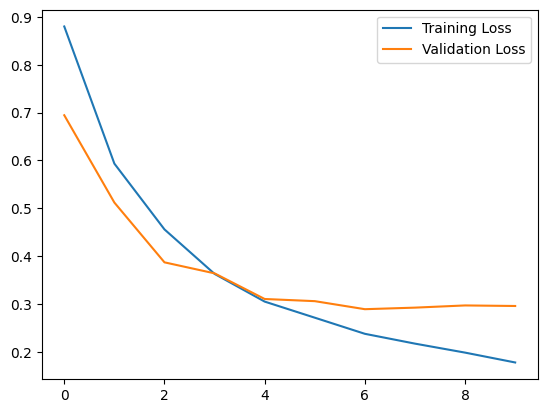

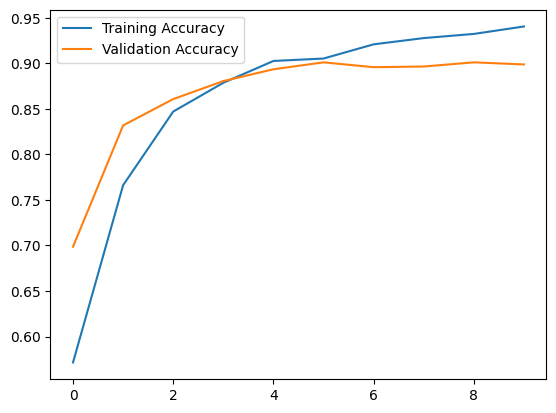

In [65]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

42/42 [==============================] - 10s 99ms/step


TFSequenceClassifierOutput(loss=None, logits=array([[-2.1619725 ,  3.6655247 , -1.0825193 ],
       [-2.598606  ,  3.4323618 , -0.9264863 ],
       [ 3.142129  , -0.8091271 , -1.1444023 ],
       ...,
       [-2.3428223 ,  3.4892814 , -0.9726433 ],
       [ 2.5812924 , -1.9076794 ,  0.82301825],
       [-2.0923853 ,  3.6416218 , -1.2106918 ]], dtype=float32), hidden_states=None, attentions=None)

42/42 [==============================] - 4s 97ms/step


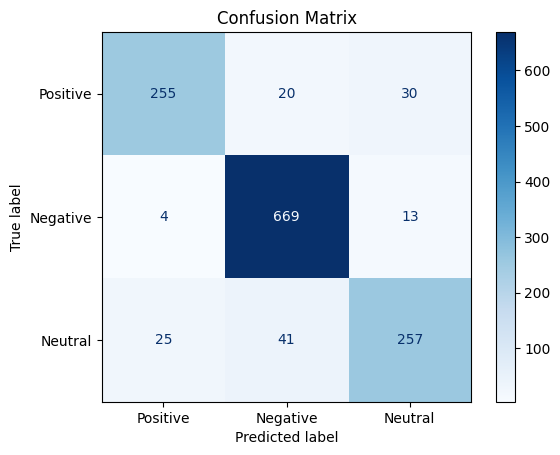

In [70]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
predictions = model.predict(val_dataset)
predicted_labels = np.argmax(predictions.logits, axis=1)

# Convert the true labels tensor to a NumPy array
true_labels = np.array(valid_labels)

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Visualize the confusion matrix
class_names = ['Positive', 'Negative', 'Neutral']  # Replace with your actual class names
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format=".4g")
plt.title("Confusion Matrix")
plt.show()

In [75]:
train_data['airline_sentiment'].value_counts()

negative    2821
neutral     1225
positive    1210
Name: airline_sentiment, dtype: int64

In [77]:
val_data['airline_sentiment'].value_counts()

negative    686
neutral     323
positive    305
Name: airline_sentiment, dtype: int64

In [78]:
balanced_df_conf['airline_sentiment'].value_counts()

negative    3507
neutral     1548
positive    1515
Name: airline_sentiment, dtype: int64

In [80]:
balanced_df['airline_sentiment'].value_counts()

negative    4178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [82]:
from sklearn.metrics import classification_report

In [84]:
print(classification_report(true_labels, predicted_labels, target_names=class_names))

              precision    recall  f1-score   support

    Positive       0.90      0.84      0.87       305
    Negative       0.92      0.98      0.94       686
     Neutral       0.86      0.80      0.83       323

    accuracy                           0.90      1314
   macro avg       0.89      0.87      0.88      1314
weighted avg       0.90      0.90      0.90      1314

